# Segmentación Semántica de Imágenes Científicas

In [5]:
import numpy as np
import tensorflow as tf
import keras.backend as K

from keras import regularizers
from keras.engine import get_source_inputs
from keras.engine.topology import Layer
from keras.models import Model
from keras.layers.merge import concatenate, add
from keras.layers import (Input, Conv2D, Conv2DTranspose,
                          UpSampling2D, MaxPooling2D, Dropout, 
                          BatchNormalization, Activation,
                          GaussianNoise, Concatenate, 
                          SpatialDropout2D)

import warnings
warnings.filterwarnings('ignore')

### U-Net
U-Net es una arquitectura inicialmente concebida para segmentación de imágenes biométricas. 

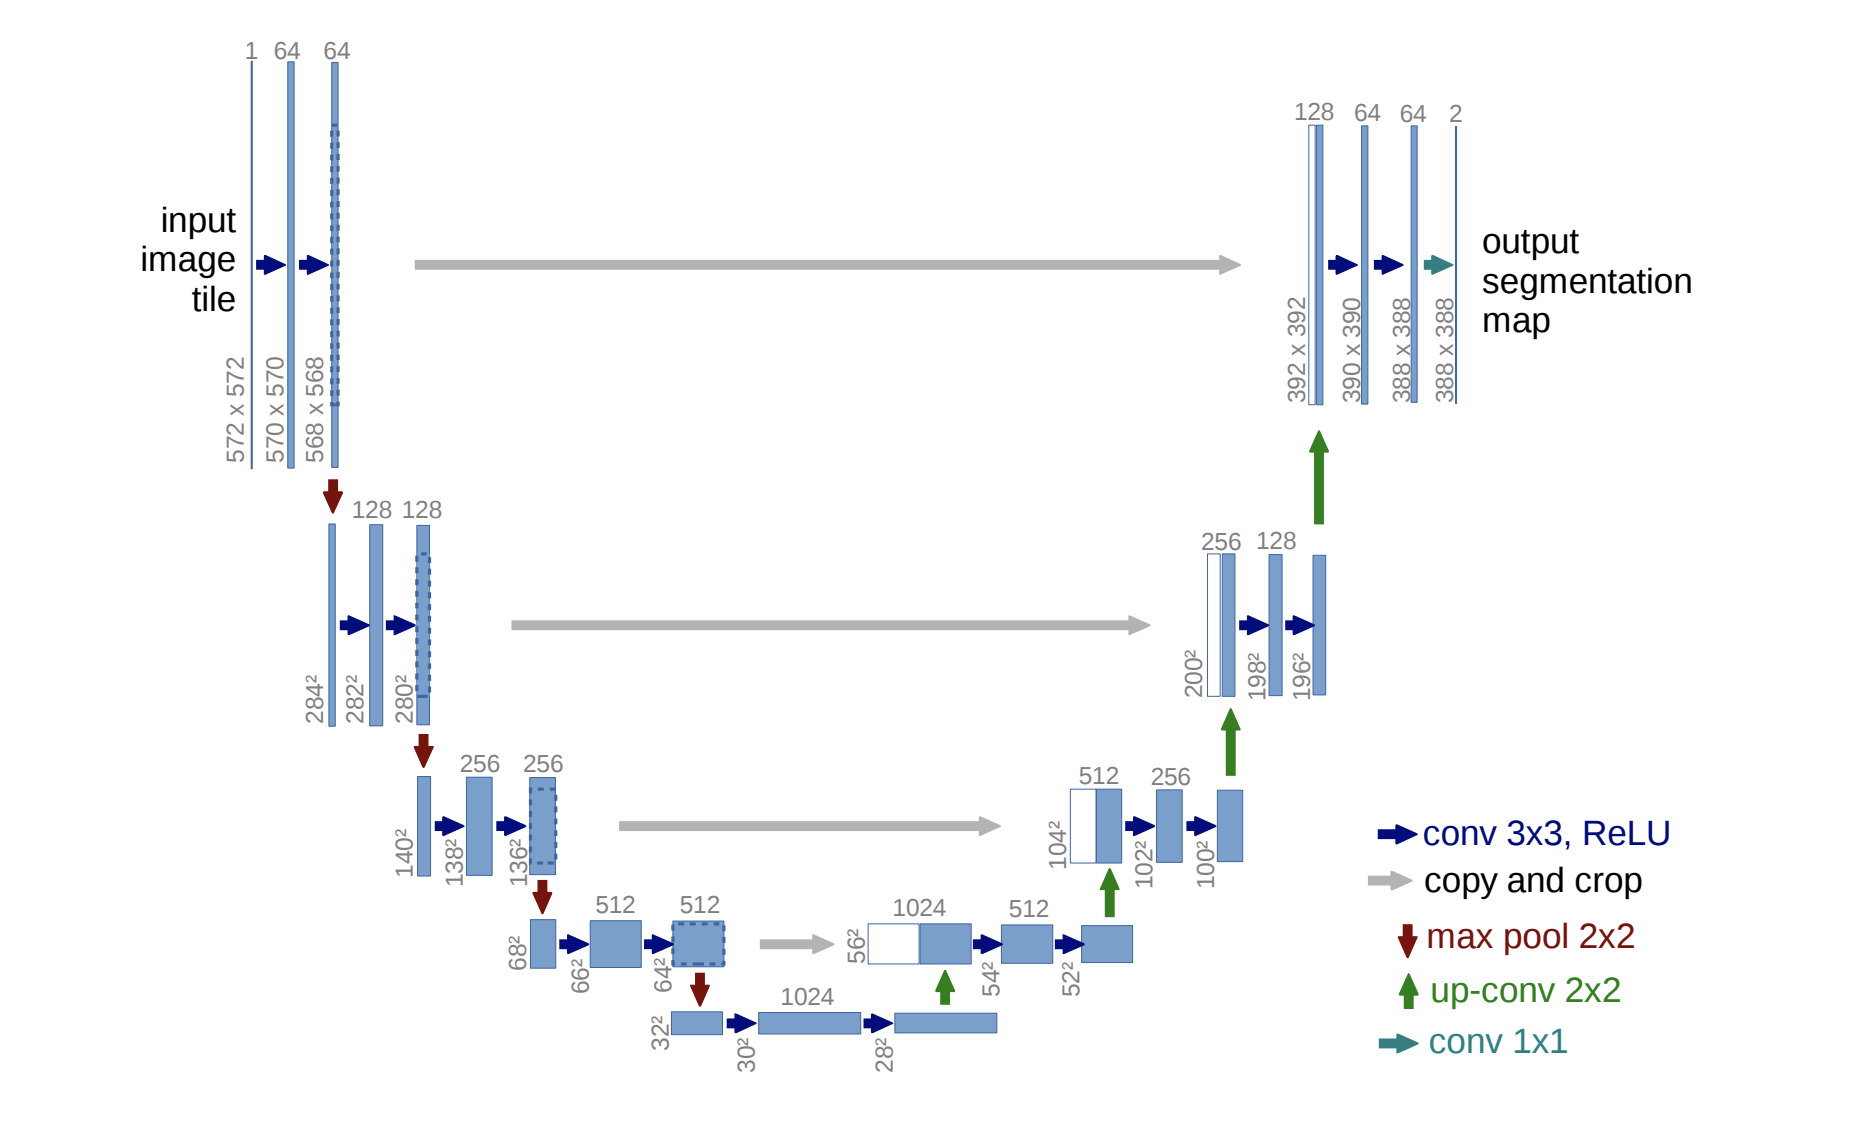

https://arxiv.org/abs/1505.04597


In [10]:
def UNet(n1_filters=32, n_bands=4, n_classes=4, 
         depth=5, kernel=(3, 3), activation='relu',
         padding='same', dilation_rate=1, input_highway=False,
         noise=0.0, learn_upsample=False, get_logits=False,
         do_batch_norm=False, dropout_val=0.0, l2_reg_val=0.0):
    inputs = Input((None, None, n_bands))
    convolutions = list()
    x = inputs
    conv_kwargs = dict(kernel_size=kernel,
                       activation=activation,
                       padding=padding,
                       dilation_rate=dilation_rate,
                       kernel_regularizer=regularizers.l2(l2_reg_val))

    for i in range(depth):
        conv = Conv2D(n1_filters * 2**i, **conv_kwargs)(x)
        if do_batch_norm: conv = BatchNormalization()(conv)
        conv = SpatialDropout2D(dropout_val)(conv)
        conv = Conv2D(n1_filters * 2**i, **conv_kwargs)(conv)
        if do_batch_norm: conv = BatchNormalization()(conv) 
        convolutions.append(conv)
        if i < depth - 1:
            x = MaxPooling2D(pool_size=(2, 2))(conv)

    for i in range(depth - 2, -1, -1):
        if learn_upsample:
            up = Conv2DTranspose(n1_filters * 2**(i+1), (2, 2), strides=(2, 2), padding=padding)(conv)
        else:
            up = UpSampling2D(size=(2, 2))(conv)
        up = concatenate([up, convolutions[i]], axis=3)
        conv = Conv2D(n1_filters * 2**i, **conv_kwargs)(up)
        if do_batch_norm: conv = BatchNormalization()(conv) 
        conv = Conv2D(n1_filters * 2**i, **conv_kwargs)(conv)
        if do_batch_norm: conv = BatchNormalization()(conv) 

    if input_highway:
        conv = concatenate([conv, inputs])

    conv = Conv2D(n_classes, (1, 1), activation='linear')(conv)
    conv = GaussianNoise(noise)(conv)  # if noise==0, this does nothing
    if get_logits:
        output = conv
    else:
        output = Activation('sigmoid')(conv)

    return Model(inputs=inputs, outputs=[output], name='UNet')


In [9]:
unet = UNet(n_bands=8, n_classes=2, dilation_rate=2)

In [109]:
import tensorflow.compat.v1 as tf
from keras.models import load_model
import tensorflow.compat.v1.keras.backend as K

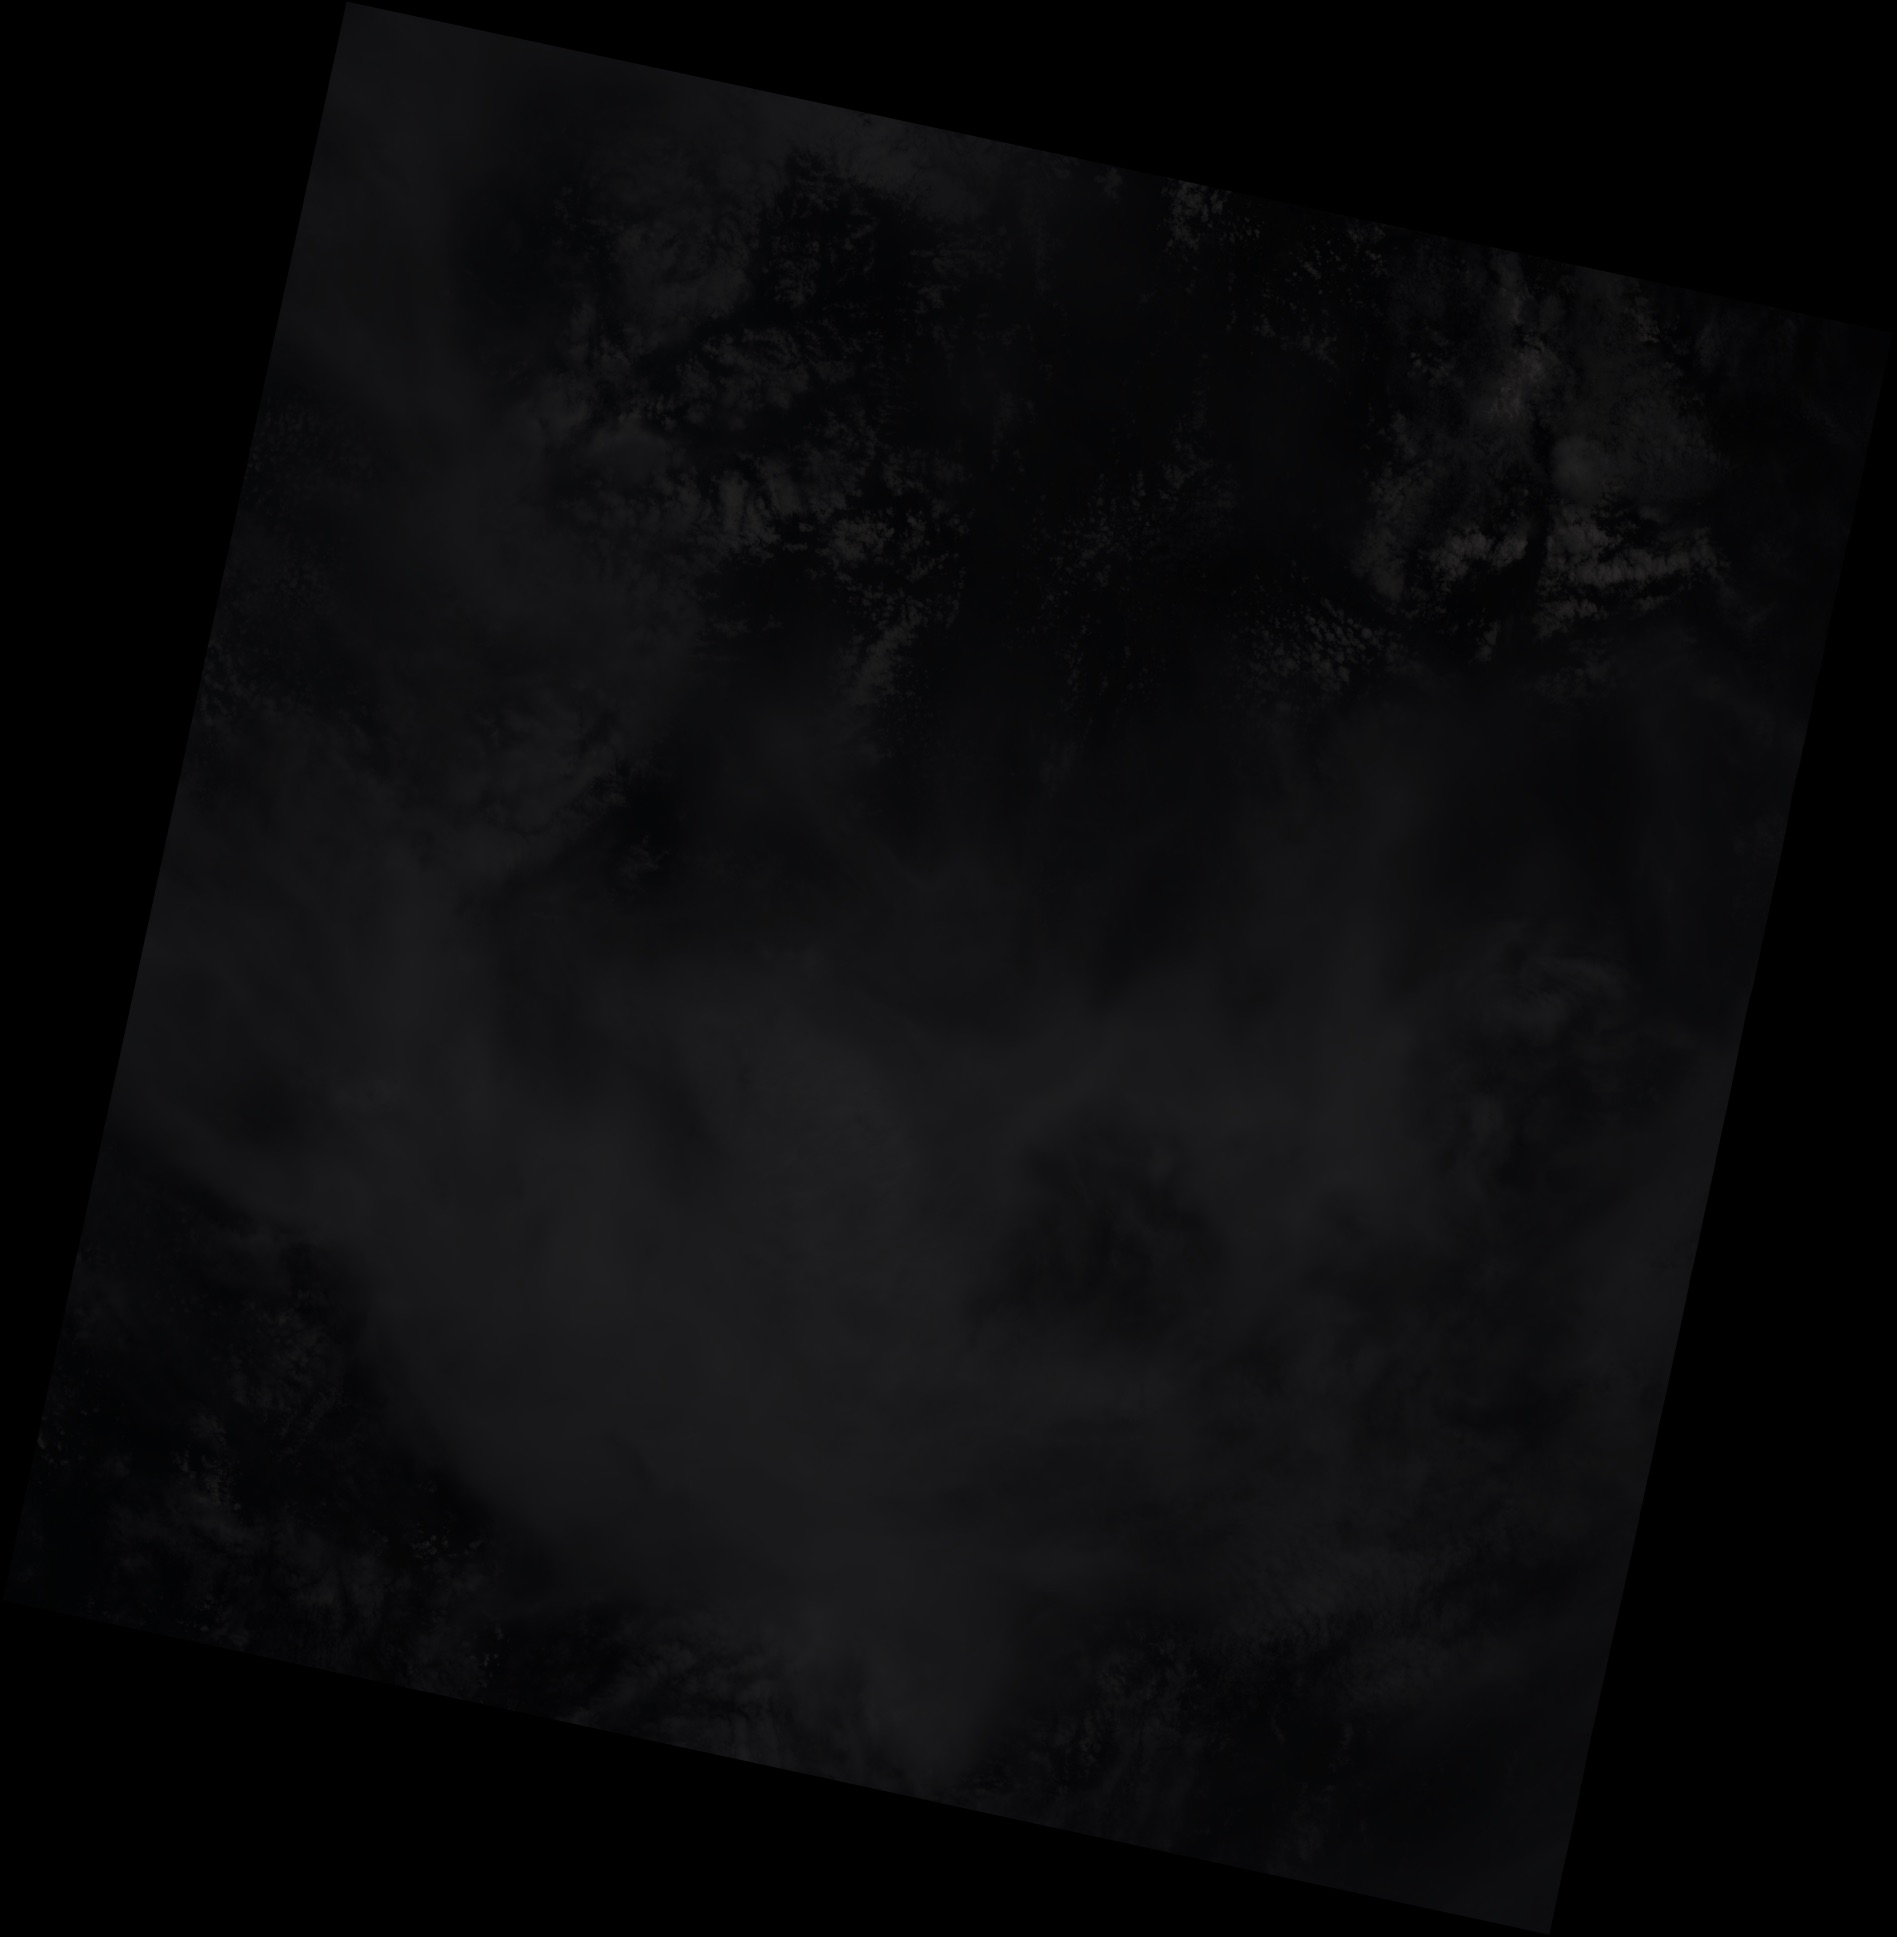

In [110]:
n_bands = 6
n_classes = 2
NUM_PARALLEL_EXEC_UNITS = 6
model_path = "weights-100-bs8_di1_bands6_seed1_freshground.hdf5"

### Mejorar el performance en CPU

`intra_op_parallelism_threads`: Number of threads used within an individual op for parallelism.

Recommend: start with the number of cores/socket on the test system, and try increasing and decreasing

`inter_op_parallelism_threads`: Number of threads used for parallelism between independent operations.

Recommend: start with the number of physical cores on the test system, and try increasing and decreasing

`device_count`: Maximum number of devices (CPUs in this case) to use.

Recommend: start with the number of cores/socket on the test system, and try increasing and decreasing

`allow_soft_placement`: Set to True/enabled to facilitate operations to be placed on CPU instead of GPU

https://software.intel.com/content/www/us/en/develop/articles/tips-to-improve-performance-for-popular-deep-learning-frameworks-on-multi-core-cpus.html

In [111]:
config = tf.ConfigProto(allow_soft_placement=True,
                        intra_op_parallelism_threads=NUM_PARALLEL_EXEC_UNITS,
                        inter_op_parallelism_threads=2,
                        log_device_placement=False)
sess = tf.Session(config=config)
K.set_session(sess)
model = load_model(model_path)

In [112]:
bands = ('red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'alpha')
this_id = "landsat:LC08:01:T1:TOAR:meta_LC08_L1TP_009057_20210417_20210424_01_T1_v1"
with open("scene.pk",  "rb") as fp:
    img = pickle.load(fp)

In [113]:
_, i, j = img.shape
proba = np.empty((i, j, n_classes), dtype='float32')

In [114]:
def generate_tiles_tight(image, tilesize, pad=0):
    n_dims = len(image.shape)
    if n_dims == 2:
        n0, n1 = image.shape
    elif n_dims == 3:
        n0, n1, _ = image.shape
    else:
        raise ValueError("Expected image of 2 or 3 dims, got %i" % n_dims)

    ni = int(np.ceil(1.0 * (n0 - 2 * pad) / tilesize))
    nj = int(np.ceil(1.0 * (n1 - 2 * pad) / tilesize))

    for i in range(0, ni):
        imin = pad + i * tilesize  # index of start of tile
        imax = imin + tilesize  # index of end of tile

        if imax + pad > n0:
            imax = n0 - pad
            imin = imax - tilesize

        for j in range(0, nj):
            jmin = pad + j * tilesize
            jmax = jmin + tilesize

            if jmax + pad > n1:
                jmax = n1 - pad
                jmin = jmax - tilesize

            tile = image[imin - pad : imax + pad, jmin - pad : jmax + pad]
            src = (slice(pad, tile.shape[0] - pad), slice(pad, tile.shape[1] - pad))
            # dest for use with unpadded result
            dest = (slice(imin - pad, imax - pad), slice(jmin - pad, jmax - pad))
            yield tile, src, dest

In [115]:
def generate_tiles_fill(image, alpha, tilesize, pad=0):
    n_dims = len(image.shape)
    if n_dims == 2:
        n0, n1 = image.shape
    elif n_dims == 3:
        n0, n1, n2 = image.shape
    else:
        raise ValueError("Expected image of 2 or 3 dims, got %i" % n_dims)

    # create padded image
    if n_dims == 2:
        image_padded = np.empty((n0 + 2 * pad, n1 + 2 * pad), dtype="float32")
    else:
        image_padded = np.empty((n0 + 2 * pad, n1 + 2 * pad, n2), dtype="float32")
    image_padded[pad : pad + n0, pad : pad + n1] = image
    
    for tile, src, dest_padded in generate_tiles_tight(image_padded, tilesize, pad=pad):
        # subtract off pad offset from destination slices.
        dest = (
            slice(dest_padded[0].start - pad, dest_padded[0].stop - pad),
            slice(dest_padded[1].start - pad, dest_padded[1].stop - pad),
        )
        yield tile, src, dest, dest_padded

In [116]:
img_use = img[:-1, ...].astype('float32') / 1e4
print(f"scene.shape: {img_use.shape}")
alpha = img[-1, ...]

scene.shape: (6, 1937, 1897)


In [118]:
img_use = img_use.reshape(1937, 1897, 6)
tiles = generate_tiles_fill(img_use, alpha, tilesize=1024-2*32, pad=32)
for tile, src, dest, dest_padded in tiles:
    proba[dest_padded] = model.predict(tile[None, ...]).squeeze()[src]


In [119]:
cloud = np.digitize(proba[:, :, 0], [0.25, 0.50, 0.75]).astype("uint8")
cloudshadow = np.digitize(proba[:, :, 1], [0.25, 0.50, 0.75]).astype("uint8")


In [120]:
print(cloud[cloud > 0.75].shape)

(1759587,)


In [121]:
print(cloudshadow[cloudshadow > 0.75].shape)

(335212,)
